# Code Improvement + Test Runner Workflow

Este notebook implementa un flujo completo en **Python** para:
1) Respaldar archivos de código, leer su contenido y enviarlo a una API de mejora.
2) Ejecutar pruebas `unittest` asociadas y agregar los resultados **en la misma fila** del DataFrame.

## Entrada esperada
Una lista de objetos con la forma:
```python
items = [
    {"file": "path/al/archivo.py", "test": "ruta/al/test_module_sin_extension", "iterations": 3},
    {"file": "otro/archivo.py", "test": "otro/test_module", "iterations": 1},
]
```
- **file**: ruta al archivo de código a mejorar (incluye `.py`).
- **test**: ruta al *módulo de pruebas* **sin** la extensión `.py` (por ejemplo `src/excercise1-fibonacci/fibonacci_test`).
- **iterations** *(opcional)*: número de veces que se envía el mismo archivo a la API. Cada envío genera **una fila** en el DataFrame.

## Salida
Un `DataFrame` con una fila por (archivo, test, iteración) incluyendo:
- Metadatos del archivo, respaldo y contenido original.
- Código mejorado y análisis devueltos por la API.
- Métricas antes/después si la API las provee.
- Resultados de pruebas (tests pasados/total, % éxito, tiempo, etc.).

---
⚙️ **Nota**: Configura `API_URL` con la URL de tu servicio (por defecto `http://127.0.0.1:8000/improve`).


In [12]:
import sys, os

# Obtiene la ruta absoluta al directorio 'src'
project_root = os.path.abspath("src")

# Si no está ya en sys.path, lo agrega
if project_root not in sys.path:
    sys.path.append(project_root)

print("PYTHONPATH actualizado con:", project_root)

PYTHONPATH actualizado con: /Users/slincastro/Projects/Master_IA/final_project/saucode/evals/src


In [13]:
# Imports
import os
import shutil
import json
from pathlib import Path
from datetime import datetime
import requests
import pandas as pd
import unittest
import sys
import time
import importlib
from io import StringIO
import contextlib
import inspect

API_URL = 'http://127.0.0.1:8000/improve'  # Cambia si tu API vive en otra URL
BACKUP_DIR = Path('backups')
BACKUP_DIR.mkdir(parents=True, exist_ok=True)


## Utilidades: respaldo de archivos y helpers


In [14]:
def backup_file(src_path: str | Path, backup_root: Path = BACKUP_DIR) -> Path:
    """Crea un respaldo timestamped del archivo y devuelve la ruta del respaldo."""
    src_path = Path(src_path)
    if not src_path.exists():
        raise FileNotFoundError(f"No existe el archivo: {src_path}")
    ts = datetime.now().strftime('%Y%m%d-%H%M%S-%f')
    dst_name = f"{src_path.stem}__{ts}{src_path.suffix}"
    dst_path = backup_root / dst_name
    shutil.copy2(src_path, dst_path)
    return dst_path

def read_text_file(path: str | Path) -> str:
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()


In [15]:
def restore_from_backup(backup_path: str, original_path: str) -> None:
    """Restaura un archivo original desde un backup específico."""
    from pathlib import Path
    import shutil
    bkp = Path(backup_path)
    orig = Path(original_path)
    if not bkp.exists():
        print(f"[WARN] Backup no encontrado: {bkp}")
        return
    try:
        shutil.copy2(bkp, orig)
    except Exception as e:
        print(f"[WARN] No se pudo restaurar {orig} desde {bkp}: {e}")


## Paso 1: Envío a API de mejora y construcción de DataFrame (por iteración)
Esta celda sigue tu contrato de API tal como fue provisto.

In [16]:
def get_test_file_path(file_path: str) -> str:
    """
    Convert a file path to its corresponding test file path by inserting '_test' 
    before the file extension.
    
    Example:
    - Input: '/path/to/module.py'
    - Output: '/path/to/module_test.py'
    
    Args:
        file_path: The original file path
        
    Returns:
        The path to the corresponding test file
    """
    if not file_path:
        return ""
        
    # Split the path into directory, filename, and extension
    directory, filename = os.path.split(file_path)
    name, ext = os.path.splitext(filename)
    
    # Create the test filename by adding '_test' before the extension
    test_filename = f"{name}_test{ext}"
    
    # Rejoin the directory with the new test filename
    test_file_path = os.path.join(directory, test_filename)
    
    return test_file_path


In [17]:
def improve_one_file(file_path: str, test_module: str, iteration: int, api_url: str = API_URL) -> dict:
    """
    Respaldar, leer y enviar un archivo a la API de mejora.
    ⚠️ Ahora REEMPLAZA el archivo original con el `improved_code` retornado por la API.
    Devuelve un diccionario listo para ser convertido a fila de DataFrame.
    """
    # 1) Respaldo y lectura
    backup_path = backup_file(file_path)
    code_content = read_text_file(file_path)
    filename = os.path.basename(file_path)

    test_content = None

    test_path = get_test_file_path(file_path)
    if test_module and os.path.exists(test_path):
        test_content = read_text_file(test_path)
    

    # 2) Envío a la API
    headers = {'Content-Type': 'application/json'}
    payload = {'Code': code_content}

    if test_content:
        payload['Tests'] = test_content
        
    resp = requests.post(api_url, headers=headers, json=payload)

    # 3) Procesamiento de la respuesta según tu contrato
    if resp.status_code == 200:
        data = resp.json()
        improved_code = data.get('Code')

        # === NUEVO: escribir el código mejorado al archivo original ===
        if isinstance(improved_code, str) and improved_code.strip():
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(improved_code)

        row = {
            'code_file': filename,
            'code_file_path': file_path,
            'test_file': test_module,
            'iteration': iteration,
            'backup_path': str(backup_path),
            'original_code': code_content,
            'improved_code': improved_code,
            'analysis': data.get('Analisis'),
        }
        # Métricas opcionales
        metrics = data.get('metrics')
        if metrics and isinstance(metrics, dict):
            before = metrics.get('before') or {}
            after = metrics.get('after') or {}
            row.update({
                'before_method_number': before.get('method_number'),
                'before_ifs': before.get('number_of_ifs'),
                'before_loops': before.get('number_of_loops'),
                'before_cyclomatic_complexity': before.get('cyclomatic_complexity'),
                'before_avg_method_size': before.get('average_method_size'),
                'after_method_number': after.get('method_number'),
                'after_ifs': after.get('number_of_ifs'),
                'after_loops': after.get('number_of_loops'),
                'after_cyclomatic_complexity': after.get('cyclomatic_complexity'),
                'after_avg_method_size': after.get('average_method_size'),
            })
        if 'RetrievedContext' in data:
            row['retrieved_context'] = json.dumps(data['RetrievedContext'])
    else:
        row = {
            'code_file': filename,
            'code_file_path': file_path,
            'test_file': test_module,
            'iteration': iteration,
            'backup_path': str(backup_path),
            'error': f"API Error: {resp.status_code}",
            'error_details': resp.text,
        }

    return row


## Paso 2: Ejecutar pruebas `unittest` y agregar resultados a las filas (mismo (file, test, iteration))
La lógica está basada en tu bloque original, adaptada para conservar la clave `(code_file_path, test_file, iteration)`.

In [68]:

import unittest
import pandas as pd
import sys
import time
import importlib
import importlib.util
import os
from io import StringIO
import contextlib
import inspect
import uuid
from pathlib import Path

def _load_module_from_path(path: str):
    """Load a python module from an absolute or relative file path."""
    path = os.path.abspath(path)
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No test file found at: {path}")
    
    # Get the directory containing the module
    module_dir = os.path.dirname(path)
    
    # Add the directory to sys.path if it's not already there
    if module_dir not in sys.path:
        sys.path.insert(0, module_dir)
    
    # Generate a unique module name
    mod_name = f"__testmod_{uuid.uuid4().hex}"
    
    # Create the spec with the package parameter
    spec = importlib.util.spec_from_file_location(
        mod_name, 
        path,
        # Add the package parameter for handling relative imports
        submodule_search_locations=[module_dir]
    )
    
    module = importlib.util.module_from_spec(spec)
    
    # Add the module to sys.modules to handle relative imports
    sys.modules[mod_name] = module
    
    spec.loader.exec_module(module)  # type: ignore[attr-defined]
    return module, path


def _guess_test_file(candidate: str) -> str:
    """
    Accepts diverse inputs:
      - a path to a test file (endswith .py) -> return as-is if exists
      - a directory path -> try to find *test*.py inside
      - a module path (dotted) -> resolve to file via __file__
    """
    # If it's an existing file, return it
    p = Path(candidate)
    if p.suffix == ".py" and p.exists():
        return str(p)

    # If it's a directory, try to find a typical unittest file
    if p.exists() and p.is_dir():
        # prefer *_test.py then test_*.py
        patterns = ["*test*.py"]
        for pattern in patterns:
            matches = sorted(p.glob(pattern))
            for m in matches:
                return str(m)
        raise FileNotFoundError(f"No test file (*.py) found under directory: {candidate}")

    # If looks like a path without .py, try adding .py
    if p.suffix == "" and p.exists():
        alt = str(p) + ".py"
        if Path(alt).exists():
            return alt

    # Try to import as module and resolve __file__
    try:
        mod = importlib.import_module(candidate)
        f = getattr(mod, "__file__", None)
        if f and os.path.isfile(f):
            return f
    except Exception:
        pass

    # Finally, if it's something like 'src/dir/name' try appending .py
    if p.suffix == "" and not p.exists():
        alt = candidate + ".py"
        if Path(alt).exists():
            return alt

    raise FileNotFoundError(f"Could not resolve a test file from: {candidate}")

def _import_test_target(file_or_module: str):
    """
    Import a test module from either a path (preferred for dirs with hyphens)
    or a dotted module path.
    """
    # Try resolve to a concrete file first (supports dirs with hyphens)
    try:
        file_path = _guess_test_file(file_or_module)
        return _load_module_from_path(file_path)
    except Exception:
        # Fallback: treat as module name (requires importable path without hyphens)
        # Also ensure 'src' is in sys.path as a convenience
        src_dir = os.path.abspath("src")
        if os.path.isdir(src_dir) and src_dir not in sys.path:
            sys.path.insert(0, src_dir)
        mod = importlib.import_module(file_or_module)
        path = getattr(mod, "__file__", file_or_module)
        return mod, path

class _ResultCollector(unittest.TextTestResult):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.test_results = []  # list[dict]

    def addSuccess(self, test):
        super().addSuccess(test)
        self.test_results.append({
            "test_name": str(test),
            "status": "PASS",
            "error_message": None
        })

    def addFailure(self, test, err):
        super().addFailure(test, err)
        from traceback import format_exception
        msg = "".join(format_exception(*err))
        self.test_results.append({
            "test_name": str(test),
            "status": "FAIL",
            "error_message": msg
        })

    def addError(self, test, err):
        super().addError(test, err)
        from traceback import format_exception
        msg = "".join(format_exception(*err))
        self.test_results.append({
            "test_name": str(test),
            "status": "ERROR",
            "error_message": msg
        })

def run_tests_for_file(file_or_module: str, iteration: int = 1) -> pd.DataFrame:
    """
    Load a unittest module and run it, returning a DataFrame with per-test results
    and a summary row.
    """
    try:
        test_module, resolved_path = _import_test_target(file_or_module)

        # Collect TestCase subclasses
        test_classes = [
            obj for _, obj in inspect.getmembers(test_module)
            if inspect.isclass(obj) and issubclass(obj, unittest.TestCase)
        ]

        # Build a suite from discovered classes
        suite = unittest.TestSuite()
        loader = unittest.TestLoader()
        for cls in test_classes:
            suite.addTests(loader.loadTestsFromTestCase(cls))

        # Run and capture stdout
        stream = StringIO()
        runner = unittest.TextTestRunner(stream=stream, verbosity=2, resultclass=_ResultCollector)
        start = time.time()
        with contextlib.redirect_stdout(stream):
            result = runner.run(suite)
        duration = time.time() - start

        # Build per-test dataframe
        rows = []
        for r in result.test_results:

            rows.append({
                "test_file": resolved_path,
                "iteration": iteration,
                "test_name": r["test_name"],
                "status": r["status"],
                "execution_time": duration,  # total; fine-grained split omitted
                "error_message": r["error_message"],
            })

        total = max(len(rows), 1)
        passed = sum(1 for r in rows if r["status"] == "PASS")
        success_rate = passed / total

        summary = {
            "test_file": resolved_path,
            "iteration": iteration,
            "tests": f"{passed}/{total} ({success_rate:.2%})",
            "percentage_of_success": round(success_rate * 100, 2),
            "execution_time": duration,
            "error": None,
            "error_details": None
        }

        df = pd.DataFrame(rows) if rows else pd.DataFrame([{
            "test_file": resolved_path, "iteration": iteration,
            "test_name": "(no tests found)", "status": "ERROR",
            "execution_time": duration, "error_message": "No unittest.TestCase classes found"
        }])
        # Return summary merged with per-test results (like previous notebook)
        summary_df = pd.DataFrame([summary])
        return df, summary_df

    except Exception as e:
        err = f"{type(e).__name__}: {e}"
        print(err)

        print()
        summary = pd.DataFrame([{
            "test_file": file_or_module,
            "iteration": iteration,
            "tests": "ERROR",
            "percentage_of_success": 0.0,
            "execution_time": 0.0,
            "error": err,
            "error_details": None
        }])
        details = pd.DataFrame([{
            "test_file": file_or_module, "iteration": iteration,
            "test_name": "(setup failure)", "status": "ERROR",
            "execution_time": 0.0, "error_message": err
        }])
        return details, summary

def _run_tests_for_file(file_or_module: str, iteration: int) -> pd.DataFrame:
    """Compatibility shim to return only the summary dataframe like the original workflow assumed."""
    _, summary_df = run_tests_for_file(file_or_module, iteration)
    return summary_df

def run_tests_for_multiple_files(file_paths, iterations: int = 1) -> pd.DataFrame:
    """Run multiple files over several iterations and combine summaries."""
    all_summaries = []
    for file_or_module in file_paths:
        for i in range(1, iterations + 1):
            _, summary_df = run_tests_for_file(file_or_module, i)
            all_summaries.append(summary_df)
    return pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame(
        columns=['test_file', 'iteration', 'tests', 'percentage_of_success', 'execution_time', 'error', 'error_details']
    )


## Orquestador: une Paso 1 + Paso 2 en un único DataFrame
Se hace un `merge` por `(test_file, iteration)` (y se conserva `code_file_path`) para garantizar que cada envío/iteración tenga los resultados de pruebas correspondientes.

In [19]:
def run_full_workflow(items: list[dict], api_url: str = API_URL) -> pd.DataFrame:
    """
    Ejecuta el flujo por **iteración**: mejora + escribe, ejecuta tests, MERGE de resultados,
    y **restaura el archivo original al final de cada iteración** usando el backup de esa iteración.
    """
    merged_rows = []
    for it in items:
        file_path = it['file']
        test_module = it['test']
        iterations = int(it.get('iterations', 1))
        for k in range(1, iterations + 1):
            # Paso 1 (iteración k): mejora y escritura del código
            improve_row = improve_one_file(file_path, test_module, k, api_url)

            # Paso 2 (iteración k): correr tests para este test_module/k
            tests_df = _run_tests_for_file(test_module, k)

            print("-"*10)
            print(test_module)
            print(tests_df)
            print("-"*10)

            # Fusionar en una sola fila
            import pandas as _pd
            improve_df_k = _pd.DataFrame([improve_row])

            if 'test_file' not in improve_df_k.columns:
                improve_df_k['test_file'] = test_module

            merged_k = improve_df_k.merge(
                tests_df,
                on=['test_file', 'iteration'],
                how='left',
                suffixes=('', '_test')
            )

            merged_k['tests'] = tests_df['tests']
            merged_k['percentage_of_success'] = tests_df['percentage_of_success']
            merged_k['execution_time'] = tests_df['execution_time']
            merged_rows.append(merged_k)

            # Restaurar inmediatamente al finalizar la iteración
            try:
                if 'backup_path' in improve_row and improve_row.get('backup_path'):
                    restore_from_backup(improve_row['backup_path'], improve_row['code_file_path'])
            except Exception as e:
                print('[WARN] Falló la restauración por iteración:', e)

    # Concatenar todas las filas y ordenar columnas
    if not merged_rows:
        return pd.DataFrame()
    out = pd.concat(merged_rows, ignore_index=True)
    preferred_cols = [
        'code_file', 'code_file_path', 'backup_path', 'test_file', 'iteration',
        'tests', 'percentage_of_success', 'execution_time',
        'original_code', 'improved_code', 'analysis', 'retrieved_context',
        'before_method_number', 'before_ifs', 'before_loops', 'before_cyclomatic_complexity', 'before_avg_method_size',
        'after_method_number', 'after_ifs', 'after_loops', 'after_cyclomatic_complexity', 'after_avg_method_size',
        'error', 'error_details'
    ]
    for col in preferred_cols:
        if col not in out.columns:
            out[col] = None
    return out[preferred_cols]


## Ejemplo de uso
Ajusta las rutas de `items` a tus archivos locales. Recuerda que `test` **no** lleva `.py`.

In [72]:
_run_tests_for_file('./src/exercise1_fibonacci/fibonacci_test.py',1)

Successfully imported execute using relative import


,test_file,iteration,tests,percentage_of_success,execution_time,error,error_details
0,/Users/slincastro/Projects/Master_IA/final_pro...,1,9/9 (100.00%),100.0,0.000757,None,None


In [71]:

items = [
    {
        'file': 'src/exercise1_fibonacci/fibonacci.py',
        'test': './src/exercise1_fibonacci/fibonacci_test.py',
        'iterations': 1
    }
    ,
    {
        'file': 'src/exercise2_factorial/factorial.py',
        'test': './src/exercise2_factorial/factorial_test.py',
        'iterations': 1
   }
   ,
    {
        'file': 'src/exercise3_calculate_pi/calculate_pi.py',
        'test': './src/exercise3_calculate_pi/calculate_pi_test.py',
        'iterations': 1
    }
   ,
    {
        'file': 'src/exercise4_hanoi/hanoi_towers.py',
        'test': './src/exercise4_hanoi/hanoi_towers_test.py',
        'iterations': 1
   },
       {
        'file': 'src/exercise5_roman_converter/roman_converter.py',
        'test': './src/exercise5_roman_converter/roman_converter_test.py',
        'iterations': 1
   }
]

try:
    df = run_full_workflow(items, api_url=API_URL)
    display(df)
except Exception as e:
    print('[WARN] No se pudo ejecutar el flujo completo aquí (por ejemplo, si la API no está disponible).')
    print('Error:', e)


Successfully imported execute using relative import
----------
./src/exercise1_fibonacci/fibonacci_test.py
                                           test_file  iteration         tests  \
0  /Users/slincastro/Projects/Master_IA/final_pro...          1  6/9 (66.67%)   

   percentage_of_success  execution_time error error_details  
0                  66.67        0.003759  None          None  
----------
----------
./src/exercise2_factorial/factorial_test.py
                                           test_file  iteration  \
0  /Users/slincastro/Projects/Master_IA/final_pro...          1   

           tests  percentage_of_success  execution_time error error_details  
0  7/7 (100.00%)                  100.0        0.000559  None          None  
----------
----------
./src/exercise3_calculate_pi/calculate_pi_test.py
                                           test_file  iteration  \
0  /Users/slincastro/Projects/Master_IA/final_pro...          1   

           tests  percentage_of_success 

,code_file,code_file_path,backup_path,test_file,iteration,tests,percentage_of_success,execution_time,original_code,improved_code,...,before_loops,before_cyclomatic_complexity,before_avg_method_size,after_method_number,after_ifs,after_loops,after_cyclomatic_complexity,after_avg_method_size,error,error_details
0,fibonacci.py,src/exercise1_fibonacci/fibonacci.py,backups/fibonacci__20251020-175132-274967.py,./src/exercise1_fibonacci/fibonacci_test.py,1,6/9 (66.67%),66.67,0.003759,"def f(a=0, b=1, n=10, x=None, c=True, *args, *...",import logging\n\nlogging.basicConfig(level=lo...,...,3,12,20.000000,1,3,1,6,28.000000,NaN,NaN
1,factorial.py,src/exercise2_factorial/factorial.py,backups/factorial__20251020-175156-287225.py,./src/exercise2_factorial/factorial_test.py,1,7/7 (100.00%),100.00,0.000559,\ndef generate_factorial():\n def factorial...,import time\nfrom clockdeco0 import clock\n\nM...,...,2,11,16.000000,3,4,1,7,9.333333,NaN,NaN
2,calculate_pi.py,src/exercise3_calculate_pi/calculate_pi.py,backups/calculate_pi__20251020-175215-465683.py,./src/exercise3_calculate_pi/calculate_pi_test.py,1,8/8 (100.00%),100.00,0.002360,# π/4 = sum_{k=0}^{n-1} (-1)^k / (2k+1)\n\nacc...,"def execute(terms=""100"", PRECISION=None, *args...",...,1,16,35.000000,2,1,1,4,14.000000,NaN,NaN
3,hanoi_towers.py,src/exercise4_hanoi/hanoi_towers.py,backups/hanoi_towers__20251020-175237-432268.py,./src/exercise4_hanoi/hanoi_towers_test.py,1,15/15 (100.00%),100.00,0.006858,# WARNING: Código intencionalmente horrible pa...,"def execute(num_disks, source=""A"", auxiliary=""...",...,1,20,48.666667,2,5,0,6,23.500000,NaN,NaN
4,roman_converter.py,src/exercise5_roman_converter/roman_converter.py,backups/roman_converter__20251020-175257-83074...,./src/exercise5_roman_converter/roman_converte...,1,12/12 (100.00%),100.00,0.000303,# WARNING: This file is intentionally terrible...,"def execute(number, options=None, *args, **kwa...",...,2,28,22.000000,2,5,2,9,30.500000,NaN,NaN


## Guardar resultados (opcional)


In [74]:
import pandas as pd
from datetime import datetime

last_filename = ""

if 'df' in globals() and isinstance(df, pd.DataFrame):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"improvement_and_tests_results_{timestamp}.csv"
    last_filename = filename
    
    df.to_csv(filename, index=False)
    print(f"Results saved in {filename}")

Results saved in improvement_and_tests_results_2025-10-20_18-01-27.csv


In [75]:
import pandas as pd

#filename = "improvement_and_tests_results_2025-10-20_17-45-32.csv"

df = pd.read_csv(last_filename)

print(df.head())

            code_file                                    code_file_path  \
0        fibonacci.py              src/exercise1_fibonacci/fibonacci.py   
1        factorial.py              src/exercise2_factorial/factorial.py   
2     calculate_pi.py        src/exercise3_calculate_pi/calculate_pi.py   
3     hanoi_towers.py               src/exercise4_hanoi/hanoi_towers.py   
4  roman_converter.py  src/exercise5_roman_converter/roman_converter.py   

                                         backup_path  \
0       backups/fibonacci__20251020-175132-274967.py   
1       backups/factorial__20251020-175156-287225.py   
2    backups/calculate_pi__20251020-175215-465683.py   
3    backups/hanoi_towers__20251020-175237-432268.py   
4  backups/roman_converter__20251020-175257-83074...   

                                           test_file  iteration  \
0        ./src/exercise1_fibonacci/fibonacci_test.py          1   
1        ./src/exercise2_factorial/factorial_test.py          1   
2  ./src/ex

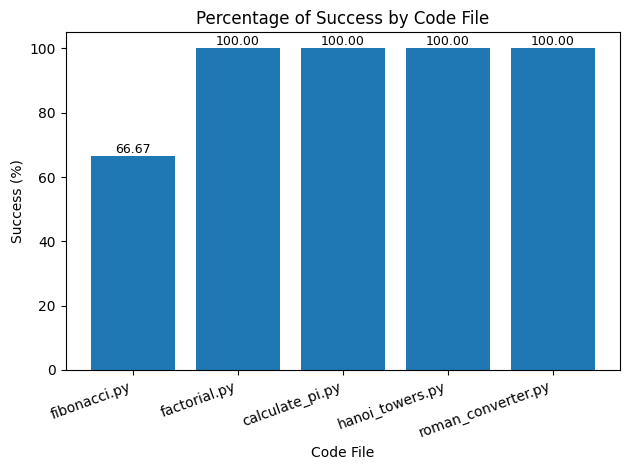

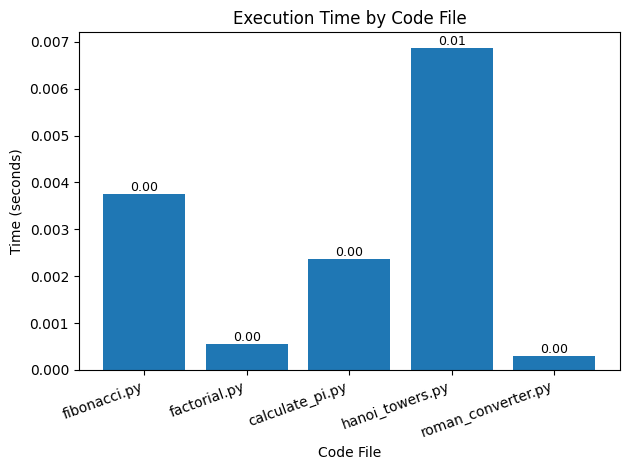

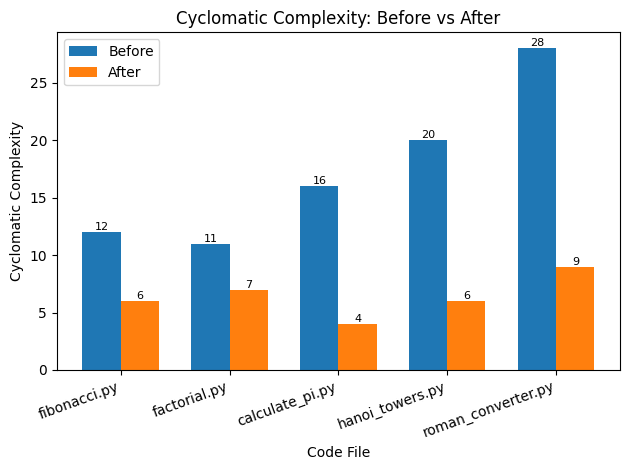

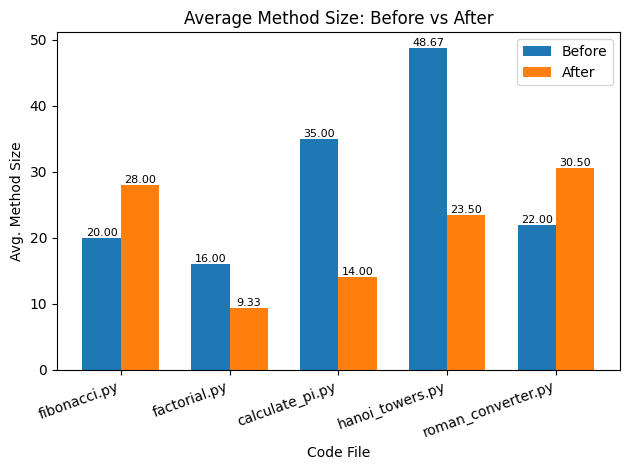

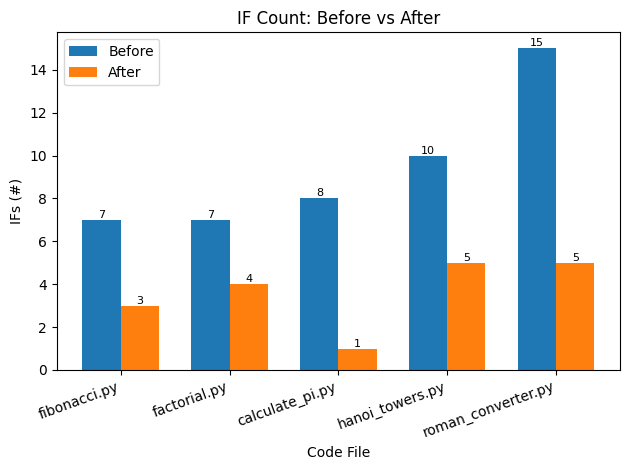

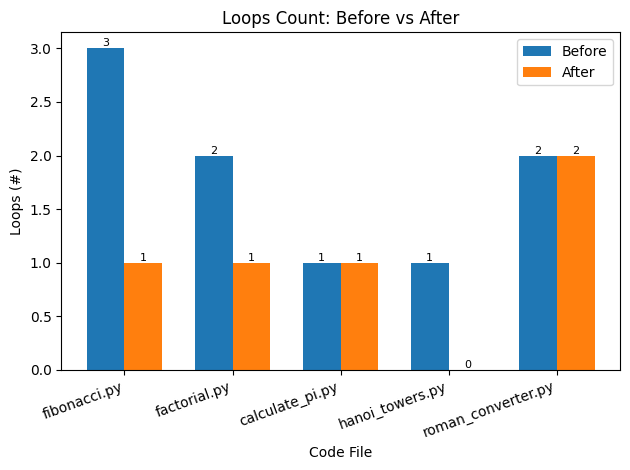

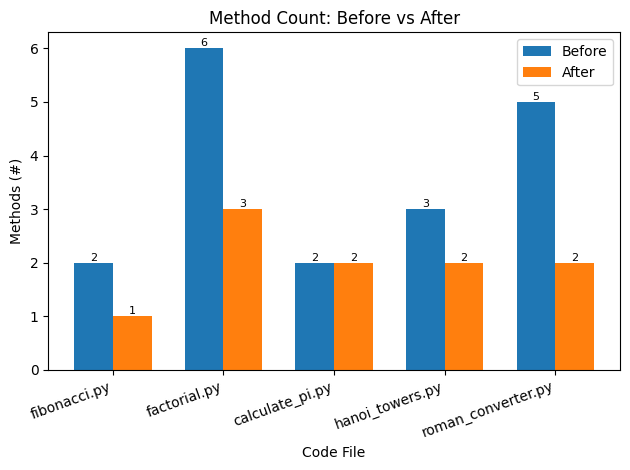

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes you already have a DataFrame named df ---
# If "percentage_of_success" is float-like, ensure numeric (strip possible % strings)
def _to_float(v):
    if isinstance(v, str):
        return float(v.replace("%", "").strip())
    return float(v)

df = df.copy()

# Normalize and order by original appearance
df["code_file"] = df["code_file"].astype(str)

# Ensure numeric columns
df["percentage_of_success"] = df["percentage_of_success"].apply(_to_float)
if "execution_time" in df.columns:
    df["execution_time"] = pd.to_numeric(df["execution_time"], errors="coerce")

def _bar_with_labels(ax, x_pos, heights, labels, rotation=0):
    ax.bar(x_pos, heights)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=rotation, ha="right")
    for xpos, h in zip(x_pos, heights):
        ax.text(xpos, h, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

# 1) Percentage of success per code_file
plt.figure()
x = np.arange(len(df))
ax = plt.gca()
_bar_with_labels(ax, x, df["percentage_of_success"].values, df["code_file"].tolist(), rotation=20)
ax.set_title("Percentage of Success by Code File")
ax.set_ylabel("Success (%)")
ax.set_xlabel("Code File")
plt.tight_layout()

# 2) Execution time per code_file (if present)
if "execution_time" in df.columns:
    plt.figure()
    x = np.arange(len(df))
    ax = plt.gca()
    _bar_with_labels(ax, x, df["execution_time"].values, df["code_file"].tolist(), rotation=20)
    ax.set_title("Execution Time by Code File")
    ax.set_ylabel("Time (seconds)")
    ax.set_xlabel("Code File")
    plt.tight_layout()

def plot_before_after(metric_name_before, metric_name_after, title, y_label):
    before = pd.to_numeric(df[metric_name_before], errors="coerce").fillna(0).values
    after  = pd.to_numeric(df[metric_name_after ], errors="coerce").fillna(0).values
    labels = df["code_file"].tolist()
    n = len(labels)
    idx = np.arange(n)
    width = 0.35

    plt.figure()
    ax = plt.gca()
    ax.bar(idx - width/2, before, width, label="Before")
    ax.bar(idx + width/2, after,  width, label="After")
    ax.set_xticks(idx)
    ax.set_xticklabels(labels, rotation=20, ha="right")
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Code File")

    # Simple bar labels
    for xpos, h in zip(idx - width/2, before):
        ax.text(xpos, h, f"{h:.2f}" if isinstance(h, float) else f"{h}", ha="center", va="bottom", fontsize=8)
    for xpos, h in zip(idx + width/2, after):
        ax.text(xpos, h, f"{h:.2f}" if isinstance(h, float) else f"{h}", ha="center", va="bottom", fontsize=8)

    ax.legend()
    plt.tight_layout()

# 3) Before vs After: cyclomatic complexity
if {"before_cyclomatic_complexity","after_cyclomatic_complexity"}.issubset(df.columns):
    plot_before_after(
        "before_cyclomatic_complexity",
        "after_cyclomatic_complexity",
        "Cyclomatic Complexity: Before vs After",
        "Cyclomatic Complexity"
    )

# 4) Before vs After: average method size
if {"before_avg_method_size","after_avg_method_size"}.issubset(df.columns):
    plot_before_after(
        "before_avg_method_size",
        "after_avg_method_size",
        "Average Method Size: Before vs After",
        "Avg. Method Size"
    )

# 5) Before vs After: IFs
if {"before_ifs","after_ifs"}.issubset(df.columns):
    plot_before_after(
        "before_ifs",
        "after_ifs",
        "IF Count: Before vs After",
        "IFs (#)"
    )

# 6) Before vs After: loops
if {"before_loops","after_loops"}.issubset(df.columns):
    plot_before_after(
        "before_loops",
        "after_loops",
        "Loops Count: Before vs After",
        "Loops (#)"
    )

# 7) Before vs After: method count (if available)
if {"before_method_number","after_method_number"}.issubset(df.columns):
    plot_before_after(
        "before_method_number",
        "after_method_number",
        "Method Count: Before vs After",
        "Methods (#)"
    )
elif {"after_method_number"}.issubset(df.columns):
    # If only 'after' exists, still show it
    plt.figure()
    x = np.arange(len(df))
    ax = plt.gca()
    _bar_with_labels(ax, x, pd.to_numeric(df["after_method_number"], errors="coerce").fillna(0).values,
                     df["code_file"].tolist(), rotation=20)
    ax.set_title("Method Count (After)")
    ax.set_ylabel("Methods (#)")
    ax.set_xlabel("Code File")
    plt.tight_layout()

plt.show()

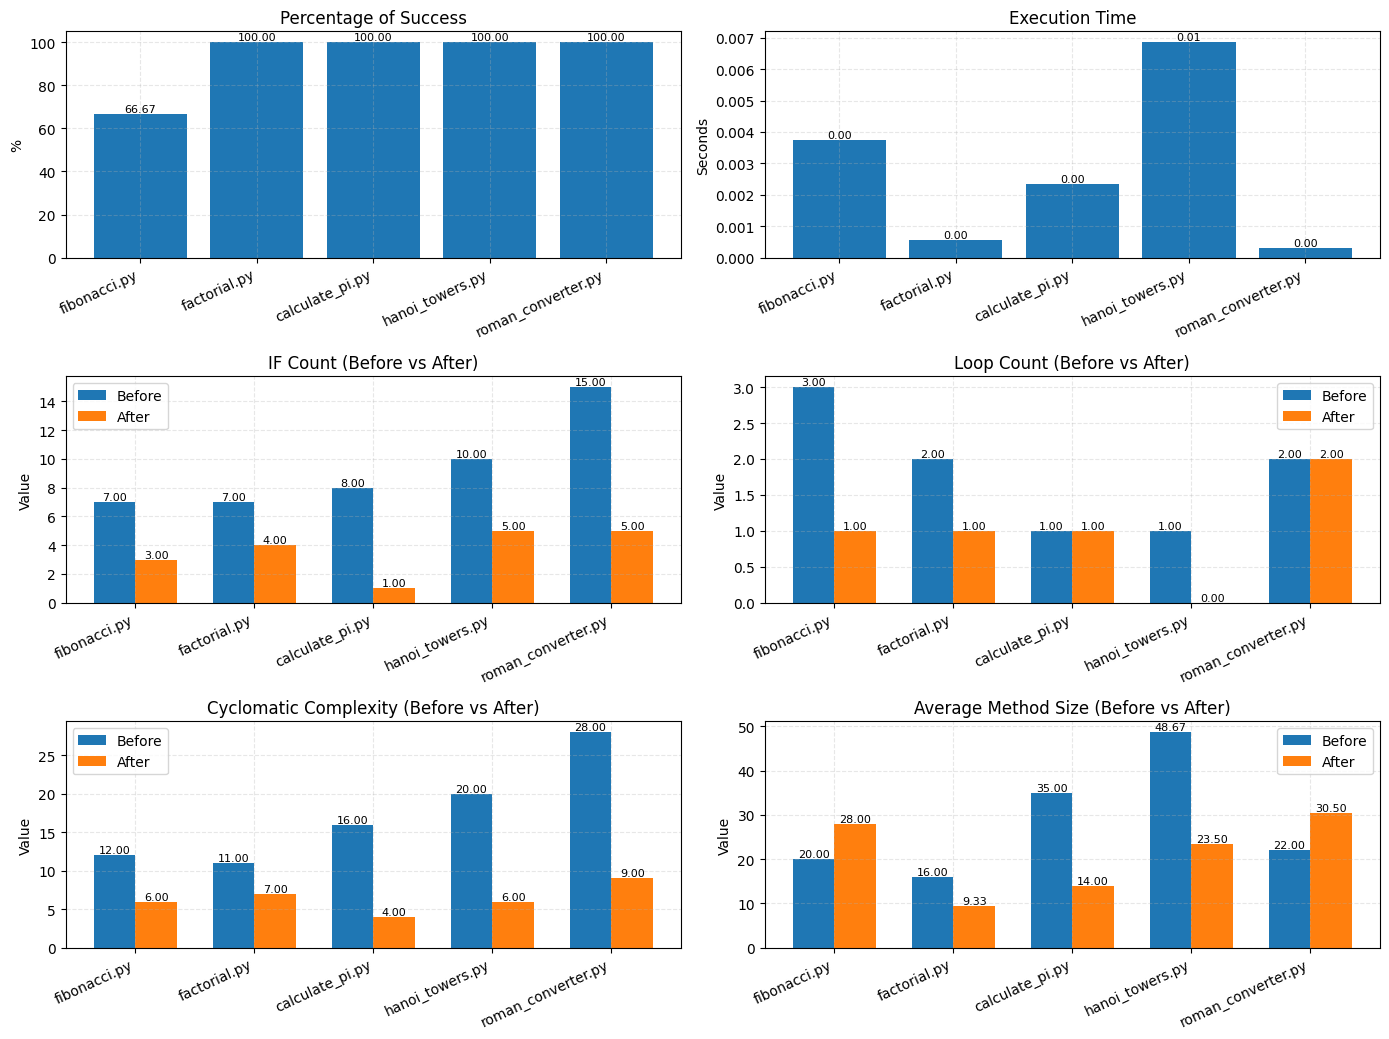

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- assumes df is already loaded ---
def _to_float(v):
    if isinstance(v, str):
        return float(v.replace("%", "").strip())
    return float(v)

df = df.copy()
df["percentage_of_success"] = df["percentage_of_success"].apply(_to_float)
df["execution_time"] = pd.to_numeric(df["execution_time"], errors="coerce")

metrics = [
    ("percentage_of_success", "Percentage of Success", "%"),
    ("execution_time", "Execution Time", "Seconds"),
]

before_after_pairs = [
    ("before_ifs", "after_ifs", "IF Count"),
    ("before_loops", "after_loops", "Loop Count"),
    ("before_cyclomatic_complexity", "after_cyclomatic_complexity", "Cyclomatic Complexity"),
    ("before_avg_method_size", "after_avg_method_size", "Average Method Size"),
]

n_metrics = len(metrics) + len(before_after_pairs)
n_cols = 2
n_rows = int(np.ceil(n_metrics / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.5 * n_rows))
axes = axes.flatten()

x = np.arange(len(df))
labels = df["code_file"].tolist()

def _add_labels(ax, xpos, heights):
    for xp, h in zip(xpos, heights):
        ax.text(xp, h, f"{h:.2f}", ha="center", va="bottom", fontsize=8)

# 1️⃣ individual metrics
for idx, (col, title, ylabel) in enumerate(metrics):
    ax = axes[idx]
    ax.bar(x, df[col])
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha="right")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    _add_labels(ax, x, df[col])
    ax.grid(True, linestyle="--", alpha=0.3)

# 2️⃣ before/after comparisons
for j, (before, after, title) in enumerate(before_after_pairs, start=len(metrics)):
    if before not in df.columns or after not in df.columns:
        continue
    ax = axes[j]
    before_vals = pd.to_numeric(df[before], errors="coerce").fillna(0).values
    after_vals = pd.to_numeric(df[after], errors="coerce").fillna(0).values
    width = 0.35
    ax.bar(x - width/2, before_vals, width, label="Before")
    ax.bar(x + width/2, after_vals, width, label="After")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha="right")
    ax.set_title(title + " (Before vs After)")
    ax.set_ylabel("Value")
    _add_labels(ax, x - width/2, before_vals)
    _add_labels(ax, x + width/2, after_vals)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.3)

# remove any empty subplots
for ax in axes[n_metrics:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()